In [1]:
import pandas as pd
import nltk
import spacy
import sys
import os

C:\Users\mathe\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
PROJECT_BASE_PATH = 'C:\\projects\\a3_test'
DATA_BASE_PATH = os.path.join(PROJECT_BASE_PATH, 'data')
SPACY_MODEL = 'en_core_web_md'

sys.path.append(PROJECT_BASE_PATH)

In [7]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [8]:
## Defining our custom functions

from src.preprocessing.text import normalize_text, remove_noisy_texts, add_textual_statistics
from src.preprocessing.reports import duplicated_report, missing_values_report
from src.analysis.companies import detect_company_name
from src.utils import printmd

from src.modeling.cluster import KPipeline
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

## Modeling 🧠💡📊

In this topic, we will leverage SciKit Learn to analyze our corpus using clusterization. By employing cluster analysis, we can uncover valuable insights regarding the composition of clusters and effectively reduce the dimensionality of the data. PyCaret provides a comprehensive set of tools and techniques that facilitate the exploration, evaluation, and interpretation of clusters, enabling us to gain a deeper understanding of our dataset. Through this approach, we aim to extract meaningful patterns and structures within the data, which can inform decision-making processes and unlock hidden insights.

For our experiment we will try 1:
   * KMeans Clusterization with word2vec

## Clusterization by KMeans

In [9]:
data = pd.read_csv(os.path.join(DATA_BASE_PATH, 'curated', 'featured.csv'))

In [10]:
data.sample(3)

,id,desc,text_length,num_sentences,token_count,text_length_outlier_bound,num_sentences_outlier_bound,token_count_outlier_bound,name
2465,a17013c0-4b24-4edf-a144-acbf7025505a,Funnel is here to put an end to manual data co...,673,8,133,no_outlier,no_outlier,no_outlier,Funnel
2363,979de07b-a9a0-40c7-9672-5fc2cc7ab16c,Sevagram is a non-profit organization that off...,138,1,24,no_outlier,no_outlier,no_outlier,Sevagram
213,79acf242-b3f2-41e1-b71f-9ca0a28bd694,WeGot is a specialist in home furnishing with ...,82,1,15,no_outlier,no_outlier,no_outlier,WeGot


### Text Preprocessing

First lets preprocess our text, removing stopwords, and lemmatizing our text to avoid bias and reduce the data complexity.

In [11]:
pipeline = KPipeline()

In [12]:
preprocessed_text = pipeline.preprocess_text(data['desc'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3452/3452 [00:00<00:00, 6333.47it/s]


In [13]:
preprocessed_text[0]

'Vectra cybersecurity platform use AI detect automatically stop attacker real time collect datum perform conclusive incident investigation specialize cloud network detection response NDR cloud datum center workload account user IoT device company offer applicationson Cognito platform address high priority use case Cognito detect Office365 Azure ad find stop attack enterprise SaaS application Microsoft 365 ecosystem Cognito Stream send security enrich metadata zeek format data lake siem Cognito Recall cloud base application store investigate threat enrich metadata Cognito Detect use AI reveal prioritize hidden unknown attacker speed Vectra found 2011 base San Jose California'

In [14]:
from wordcloud import WordCloud

Lets show a wordcloud to understand better which words are more present on the preprocessed text

(-0.5, 1199.5, 699.5, -0.5)

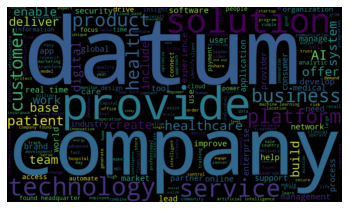

In [15]:
# Generate a word cloud image
wordcloud = WordCloud(
    width=1200, height=700
).generate(' '.join(preprocessed_text))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Now lets vectorize our preprocessed to text to input in a model, instead of using populars approaches like TFIDF and BOW lets use Word2Vec, thats can gather semantic correlations between the words.

### Word2Vec

In [16]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models import KeyedVectors
from gensim.models.phrases import Phrases, Phraser
import time

C:\Users\mathe\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
INFO - 23:45:50: adding document #0 to Dictionary<0 unique tokens: []>
INFO - 23:45:50: built Dictionary<12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...> from 9 documents (total 29 corpus positions)
INFO - 23:45:50: Dictionary lifecycle event {'msg': "built Dictionary<12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...> from 9 documents (total 29 corpus positions)", 'datetime': '2023-05-21T23:45:50.598930', 'gensim': '4.3.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


Lets prepare our data for Word2Vec model

### Bigram data

The following process helps capture multi-word expressions and can improve the quality of subsequent analyses, such as topic modeling or word embeddings. In this case we will use it to automatically capture most commom phrases from sentences, they also form a bigram.

In [17]:
sent = [row.split() for row in preprocessed_text]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 23:45:51: collecting all words and their counts
INFO - 23:45:51: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 23:45:51: collected 140406 token types (unigram + bigrams) from a corpus of 169218 words and 3452 sentences
INFO - 23:45:51: merged Phrases<140406 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 23:45:51: Phrases lifecycle event {'msg': 'built Phrases<140406 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.25s', 'datetime': '2023-05-21T23:45:51.285984', 'gensim': '4.3.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
INFO - 23:45:51: exporting phrases from Phrases<140406 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 23:45:51: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<69 phrases, min_count=30, threshold=10.0> from Phrases<140406 vocab, min_count=30, threshold=10.0, max_vocab_

In [18]:
sentences

In [19]:
from collections import Counter

# Flatten the list of lists into a single list
all_words = [word for sublist in sentences for word in sublist]

# Count the frequency of each word
word_counts = Counter(all_words)

# Sort the word counts in descending order
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [20]:
sorted_counts[:10]

[('company', 2009),
 ('platform', 1831),
 ('datum', 1321),
 ('provide', 1234),
 ('technology', 1136),
 ('solution', 1132),
 ('service', 1087),
 ('customer', 981),
 ('help', 915),
 ('business', 912)]

In [21]:
sorted_counts[-10:]

[('1980', 1),
 ('Leandro', 1),
 ('everysecond', 1),
 ('tornado', 1),
 ('AA', 1),
 ('andfit', 1),
 ('LUCIRA', 1),
 ('intertech', 1),
 ('forvarious', 1),
 ('vandalism', 1)]

Below we can check the most commons bigrams

In [22]:
list(phrases.find_phrases(sent).items())[:10]

[('real_time', 136.3583590866312),
 ('use_case', 20.993720095693778),
 ('cloud_base', 36.67039839625039),
 ('found_2011', 29.108042164351666),
 ('base_San', 12.21938756480549),
 ('e_commerce', 451.3432494279176),
 ('found_2015', 63.78647888923592),
 ('high_quality', 59.33977523772933),
 ('customer_experience', 14.239087976360123),
 ('supply_chain', 490.41820456678136)]

### Build the model

In [23]:
w2v_model = Word2Vec(min_count=30,
                     window=10,
                     vector_size=50,
                     workers=4)

INFO - 23:45:54: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=50, alpha=0.025>', 'datetime': '2023-05-21T23:45:54.211840', 'gensim': '4.3.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


#### Vocab

In [24]:
w2v_model.build_vocab(sentences, progress_per=10000)

INFO - 23:45:54: collecting all words and their counts
INFO - 23:45:54: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 23:45:54: collected 20216 word types from a corpus of 164845 raw words and 3452 sentences
INFO - 23:45:54: Creating a fresh vocabulary
INFO - 23:45:54: Word2Vec lifecycle event {'msg': 'effective_min_count=30 retains 996 unique words (4.93% of original 20216, drops 19220)', 'datetime': '2023-05-21T23:45:54.767881', 'gensim': '4.3.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO - 23:45:54: Word2Vec lifecycle event {'msg': 'effective_min_count=30 leaves 110103 word corpus (66.79% of original 164845, drops 54742)', 'datetime': '2023-05-21T23:45:54.767881', 'gensim': '4.3.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO - 23:45:54: dele

In [25]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

INFO - 23:45:55: Word2Vec lifecycle event {'msg': 'training model with 4 workers on 996 vocabulary and 50 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2023-05-21T23:45:55.103918', 'gensim': '4.3.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
INFO - 23:45:55: EPOCH 0: training on 164845 raw words (94644 effective words) took 0.3s, 370367 effective words/s
INFO - 23:45:55: EPOCH 1: training on 164845 raw words (94520 effective words) took 0.3s, 358677 effective words/s
INFO - 23:45:55: EPOCH 2: training on 164845 raw words (94540 effective words) took 0.3s, 370898 effective words/s
INFO - 23:45:56: EPOCH 3: training on 164845 raw words (94742 effective words) took 0.2s, 379033 effective words/s
INFO - 23:45:56: EPOCH 4: training on 164845 raw words (94631 effective words) took 0.3s, 370950 effective words/s
INFO - 23:45:56: EPOCH 5: training on

(2839045, 4945350)

### Lets Analysize

Lets check in our word2vec models some words similarity

In [31]:
w2v_model.wv.most_similar(positive=["industry"])

[('innovation', 0.5773265361785889),
 ('sector', 0.5523201823234558),
 ('manufacturing', 0.5237802863121033),
 ('financial_service', 0.502993643283844),
 ('market', 0.46635016798973083),
 ('firm', 0.46527281403541565),
 ('engineering', 0.4405854046344757),
 ('world_class', 0.4115391969680786),
 ('technology', 0.40877485275268555),
 ('government', 0.4066818952560425)]

In [32]:
w2v_model.wv.most_similar(positive=["health"])

[('health_care', 0.6783728003501892),
 ('healthcare', 0.6694887280464172),
 ('population', 0.6538257598876953),
 ('care', 0.5940485000610352),
 ('behavioral', 0.59393310546875),
 ('assist', 0.5905578136444092),
 ('mental', 0.5848016142845154),
 ('health_plan', 0.5709306597709656),
 ('wellness', 0.5680117011070251),
 ('clinic', 0.5677362680435181)]

In [33]:
w2v_model.wv.most_similar(positive=["security"])

[('cybersecurity', 0.7443768382072449),
 ('threat', 0.7347331047058105),
 ('protection', 0.7299214005470276),
 ('attack', 0.6648440361022949),
 ('response', 0.6047664284706116),
 ('protect', 0.5997428297996521),
 ('Security', 0.5789488554000854),
 ('cyber', 0.5674246549606323),
 ('sensitive', 0.5654309391975403),
 ('vendor', 0.5629333257675171)]

In [34]:
w2v_model.wv.most_similar(positive=["big_datum"])

[('artificial_intelligence', 0.7348484992980957),
 ('machine_learn', 0.7198577523231506),
 ('predictive', 0.7048218250274658),
 ('advanced', 0.6893791556358337),
 ('Artificial_Intelligence', 0.6696293354034424),
 ('engine', 0.6689944267272949),
 ('machine_learning', 0.6650936007499695),
 ('apply', 0.6573071479797363),
 ('algorithm', 0.6520746946334839),
 ('proprietary', 0.65143883228302)]

In [30]:
w2v_model.wv.most_similar(positive=["doctor"])

[('appointment', 0.7520332336425781),
 ('consultation', 0.7516988515853882),
 ('clinic', 0.7271532416343689),
 ('healthcare_provider', 0.7163151502609253),
 ('therapist', 0.6532019972801208),
 ('family', 0.6483581066131592),
 ('pharmacy', 0.6357461810112),
 ('patient', 0.6298717856407166),
 ('primary_care', 0.6134478449821472),
 ('receive', 0.6070359945297241)]

As we can see above there, the model is correlating near terms and their semantic significancy.

### Analogies

Lets try to check if our wav2vec model can make some analogies

*What word is to doctor as company is to developer?*

In [35]:
w2v_model.wv.most_similar(positive=["doctor", "company"], negative=["developer"], topn=4)

[('healthcare_provider', 0.5976635813713074),
 ('clinic', 0.5976130962371826),
 ('pharmacy', 0.5399656295776367),
 ('India', 0.5370372533798218)]

In [36]:
from src.analysis.text import tsnescatterplot

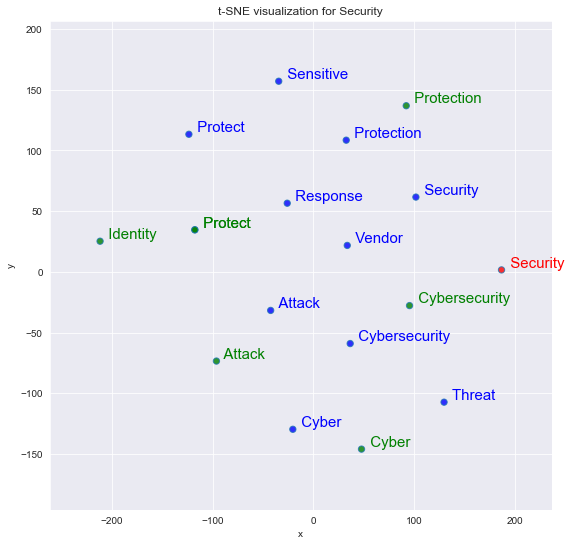

In [37]:
tsnescatterplot(w2v_model, 'security', ['protect', 'cybersecurity', 'protection', 'protect', 'attack', 'cyber', 'identity'])

As we can see, the security term is highly associated with others security terms, teir near of then in their spatial proximity.

In [38]:
len(preprocessed_text)

3452

### Training Pipeline

Lets create our Pipeline to vectorize with word2vec.

Base on the previous analysis, the kmeans model will have 4 cluster.

Based on Security, Manufacture, Health and Marketing industries.

In [39]:
from tqdm import tqdm
from src.modeling.cluster import KPipeline
import numpy as np

In [40]:
pipeline = KPipeline()

In [41]:
vectors = pipeline.prepare(df=data, text_column='desc', w2v_model=w2v_model)

INFO - 23:46:53: Preprocessing texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3452/3452 [00:00<00:00, 6959.12it/s]
INFO - 23:47:36: Vectorizing the texts...


In [42]:
clustering = pipeline.mbkmeans_clusters(
    k=6,
    mb=500,
    print_silhouette_values=True
)

C:\Users\mathe\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mathe\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


For n_clusters = 6
Silhouette coefficient: 0.68
Inertia:376.144109386215
Silhouette values:
    Cluster 1: Size:28 | Avg:1.00 | Min:1.00 | Max: 1.00
    Cluster 5: Size:1797 | Avg:1.00 | Min:0.49 | Max: 1.00
    Cluster 3: Size:374 | Avg:0.40 | Min:-0.45 | Max: 0.63
    Cluster 0: Size:696 | Avg:0.31 | Min:-0.40 | Max: 0.58
    Cluster 4: Size:478 | Avg:0.30 | Min:-0.27 | Max: 0.55
    Cluster 2: Size:79 | Avg:0.23 | Min:-0.22 | Max: 0.46


Lets check which words more represents each cluster

In [43]:
print("Most representative terms per cluster (based on centroids):")
for i in range(4):
    tokens_per_cluster = ""
    most_representative = w2v_model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: s love want know not 
Cluster 1: SaaS view founder audience medication 
Cluster 2: s 3 love month know 
Cluster 3: s love want know not 


In [44]:
test_cluster = 1
most_representative_docs = np.argsort(
    np.linalg.norm(vectors - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:3]:
    print(data['desc'][d])
    print("-------------")

Bigid is a internet marketing agency that provides digital marketing.
-------------
SafelyYou is the artificial intelligence-enabled fall detection and prevention for dementia care.
-------------
Connecting doctors and patients with clinical trials
-------------


In [50]:
data['cluster_label'] = clustering.labels_

### Distribution

Distribution of companies by clusters

<Axes: >

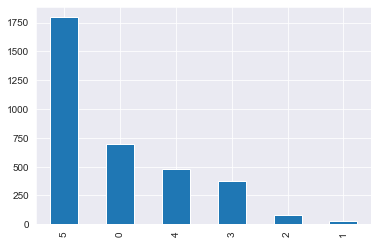

In [51]:
data['cluster_label'].value_counts().plot.bar()

In [54]:
data[data['cluster_label'] == 1].sample(5).to_dict(orient='records')

[{'id': 'c40f9973-4ca3-4b52-a4cd-1f9b7299f168',
  'desc': 'Helpmy is a caregiver application for elders and families.',
  'text_length': 58,
  'num_sentences': 1,
  'token_count': 10,
  'text_length_outlier_bound': 'no_outlier',
  'num_sentences_outlier_bound': 'no_outlier',
  'token_count_outlier_bound': 'no_outlier',
  'name': 'Helpmy',
  'cluster_label': 1},
 {'id': '1796ce30-1043-4d8b-ac77-b278f18e8bb5',
  'desc': 'FineHeal is a platform that connects patients and family with healthcare providers.',
  'text_length': 83,
  'num_sentences': 1,
  'token_count': 13,
  'text_length_outlier_bound': 'no_outlier',
  'num_sentences_outlier_bound': 'no_outlier',
  'token_count_outlier_bound': 'no_outlier',
  'name': 'FineHeal ',
  'cluster_label': 1},
 {'id': '53be59c3-47c6-49a0-9d39-83973e4b74dd',
  'desc': 'Connecting doctors and patients with clinical trials',
  'text_length': 52,
  'num_sentences': 1,
  'token_count': 7,
  'text_length_outlier_bound': 'no_outlier',
  'num_sentences_outli

In [55]:
df = data.copy()

df['desc_norm'] = preprocessed_text

In [56]:
import pandas as pd
from collections import Counter

# Assuming your original dataset is a Pandas DataFrame called 'df'
# 'desc' column contains the descriptions and 'cluster_label' column contains the cluster labels

# Create an empty DataFrame to store the results
top_words_df = pd.DataFrame(columns=['cluster_label', 'word', 'frequency'])

# Get the unique cluster labels in the dataset
unique_clusters = df['cluster_label'].unique()

# Iterate over each cluster label and find the top 10 most frequent words
for cluster_label in unique_clusters:
    # Filter the DataFrame for the current cluster
    cluster_df = df[df['cluster_label'] == cluster_label]
    
    # Concatenate all the descriptions for the current cluster
    descriptions = ' '.join(cluster_df['desc_norm'].tolist())
    
    # Split the text into individual words
    words = descriptions.split()
    
    # Count the frequency of each word
    word_counts = Counter(words)
    
    # Get the top 10 most frequent words
    top_words = word_counts.most_common(10)
    
    # Create a DataFrame for the current cluster's top words
    cluster_top_words_df = pd.DataFrame(top_words, columns=['word', 'frequency'])
    cluster_top_words_df['cluster_label'] = cluster_label
    
    # Append the current cluster's top words DataFrame to the overall top words DataFrame
    top_words_df = pd.concat([top_words_df, cluster_top_words_df], ignore_index=True)

# Sort the DataFrame by cluster_label and frequency
top_words_df = top_words_df.sort_values(by=['cluster_label', 'frequency'], ascending=[True, False])

# Print the top 10 most frequent words by cluster_label
for cluster_label in unique_clusters:
    cluster_words_df = top_words_df[top_words_df['cluster_label'] == cluster_label]
    print(f"Cluster {cluster_label}:")
    print(cluster_words_df.head(10))
    print()

Cluster 4:
  cluster_label         word frequency
0             4      company       439
1             4        found       284
2             4     platform       279
3             4         base       189
4             4   technology       167
5             4        datum       149
6             4      service       147
7             4      provide       145
8             4  headquarter       138
9             4     customer       123

Cluster 5:
   cluster_label        word frequency
10             5    platform       796
11             5     company       725
12             5       datum       616
13             5     provide       562
14             5    solution       513
15             5     service       497
16             5  technology       493
17             5     patient       433
18             5      health       418
19             5    customer       407

Cluster 0:
   cluster_label        word frequency
20             0     company       672
21             0    platform 

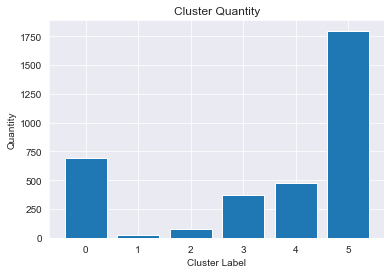

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is a Pandas DataFrame called 'df'
# 'cluster_label' column contains the cluster labels

# Count the number of instances in each cluster
cluster_counts = df['cluster_label'].value_counts()

# Create a bar plot to visualize the cluster quantity
plt.bar(cluster_counts.index, cluster_counts.values)

# Set labels and title for the plot
plt.xlabel('Cluster Label')
plt.ylabel('Quantity')
plt.title('Cluster Quantity')

# Display the plot
plt.show()

## Conclusions

Based on the new results, here are some insights and information you can gather:

Cluster 0: The most frequent words in this cluster include 'company,' 'platform,' 'datum,' 'found,' 'customer,' 'technology,' 'service,' 'base,' 'provide,' and 'solution.' This cluster might represent descriptions related to companies, platforms, and services in various industries.

Cluster 1: This cluster has lower frequencies and includes terms like 'patient,' 'platform,' 'management,' 'company,' 'enable,' 'AI,' 'healthcare,' 'build,' 'communication,' and 'doctor.' This cluster might represent descriptions related to healthcare management, platforms, and communication tools, with a focus on patient-related aspects.

Cluster 2: This cluster has lower frequencies overall. The most frequent words include 'company,' 'found,' 'platform,' 'headquarter,' 'datum,' 'provide,' 'customer,' 'help,' 'base,' and 'health.' This cluster might represent descriptions related to companies, platforms, and services, with a possible focus on the healthcare or health-related domain.

Cluster 3: This cluster also contains frequent terms like 'company,' 'platform,' 'datum,' 'provide,' 'solution,' 'service,' 'customer,' 'business,' 'base,' and 'technology.' This cluster might represent descriptions related to companies, platforms, and services in various industries, with a particular emphasis on business-related aspects.

Cluster 4: The most frequent words in this cluster include 'company,' 'found,' 'platform,' 'base,' 'technology,' 'datum,' 'service,' 'provide,' 'headquarter,' and 'customer.' This cluster might represent descriptions related to companies, platforms, and services in various industries.

Cluster 5: This cluster has high frequencies for terms like 'platform,' 'company,' 'datum,' 'provide,' 'solution,' 'service,' 'technology,' 'patient,' 'health,' and 'customer.' This cluster might represent descriptions related to platforms and services in the healthcare or patient-focused domain.


By analyzing the most frequent words in each cluster, you can gain insights into the common terms and themes associated with each cluster. This analysis can help you identify patterns, similarities, and differences among the clusters and provide insights into the underlying topics or categories represented by each cluster.

In conclusion, Word2Vec embeddings have proven to be valuable in capturing semantic relationships and similarities between words in text data. The embeddings enable various operations, such as word analogies and measuring text similarity, which offer insights into the underlying semantic structure of the data. However, when applying K-means clustering to short descriptions for sector segmentation, the results may not meet expectations due to certain factors. Insufficient or inconsistent data quality, inadequate representation of sector-specific information in the embeddings, and an incorrect number of clusters are potential reasons for suboptimal clustering outcomes. Additionally, the limited amount of data may impact the effectiveness of the K-means algorithm. Exploring alternative feature representations, considering other relevant features, and evaluating the clustering results with domain knowledge are recommended steps to enhance sector-based clustering accuracy.